In [113]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error
import librosa
import os
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import gdown
from zipfile import ZipFile as extract_zip
import seaborn as sns
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

In [114]:
file_url = "https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA"
gdown.download(file_url, "DSL_Winter_Project_2025.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA
From (redirected): https://drive.google.com/uc?id=1FcWrBIg63MwV26DE0882baBarakUb3HA&confirm=t&uuid=3f0b1802-61b0-4f28-8a57-ee823a687992
To: d:\Universita\DataScience\PrimoAnno\DataScienceLab\Assignment\DSL_Winter_Project_2025.zip
100%|██████████| 1.24G/1.24G [04:45<00:00, 4.34MB/s]


'DSL_Winter_Project_2025.zip'

In [115]:
with extract_zip("./DSL_Winter_Project_2025.zip") as num:
    num.extractall(".")

In [163]:
complete_dev_df= pd.read_csv("DSL_Winter_Project_2025/development.csv", index_col=False)
complete_eval_df= pd.read_csv("DSL_Winter_Project_2025/evaluation.csv", index_col=False)

In [164]:
complete_dev_df.describe()

,Id,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.000000,2933.0,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,1466.000000,22050.0,27.897886,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,-74.526288,41.307535,167.936243,12.423116,13.501159
std,846.828495,0.0,13.093316,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,38.446856,32.782431,133.816974,14.273205,10.839142
min,0.000000,22050.0,6.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,733.000000,22050.0,19.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,1466.000000,22050.0,23.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,2199.000000,22050.0,32.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,-40.339359,69.000000,281.000000,20.000000,21.408798
max,2932.000000,22050.0,97.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,12.403661,69.000000,281.000000,97.000000,83.777596


In [165]:
def plot_age_histogram(data, column, bin_size=5):
    ages = data[column]
    
    min_age = int(ages.min())
    max_age = int(ages.max())
    bins = np.arange(min_age, max_age + bin_size, bin_size)
    
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=bins, edgecolor='black', alpha=0.7)
    plt.title("Age Distribution (Grouped by 5 Years)", fontsize=14)
    plt.xlabel("Age Groups", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(bins, rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

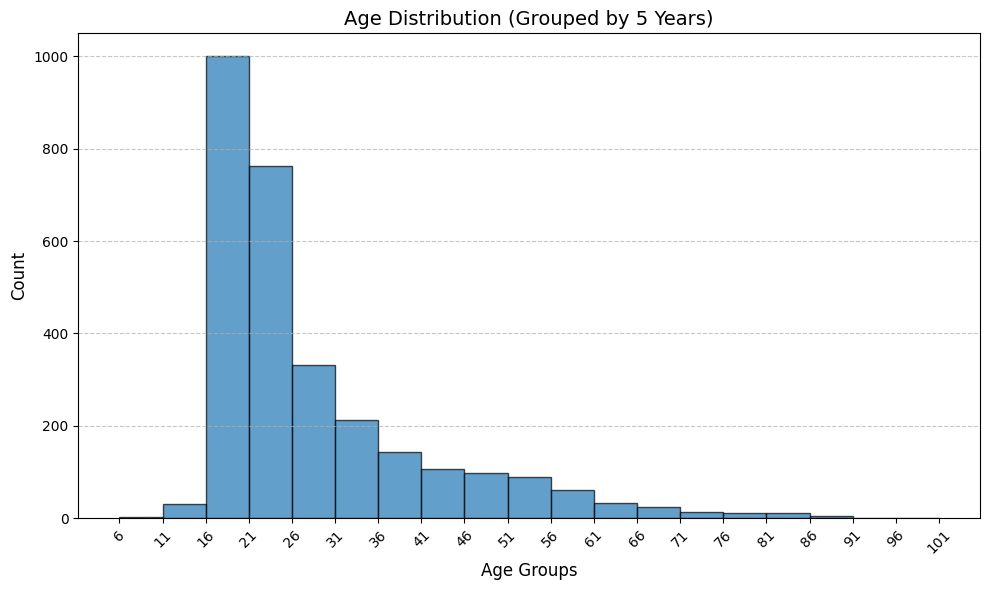

In [166]:
plot_age_histogram(complete_dev_df, "age")

In [167]:
def preprocessing(df):
    df_=df.drop(columns=["Id"], inplace=False)
    df_["tempo"] = df_["tempo"].apply(lambda x: float(x.strip("[]")))
    df_["gender"] = np.where(df_["gender"]=="male", 0,1)
    return df_

In [168]:
dev_df = preprocessing(complete_dev_df)
eval_df = preprocessing(complete_eval_df)

In [169]:
def correlation_matrix(df):
    plt.figure(figsize=(10,10))
    correlation = df.corr()
    sns.heatmap(correlation, annot=False, cmap="coolwarm")
    plt.show()

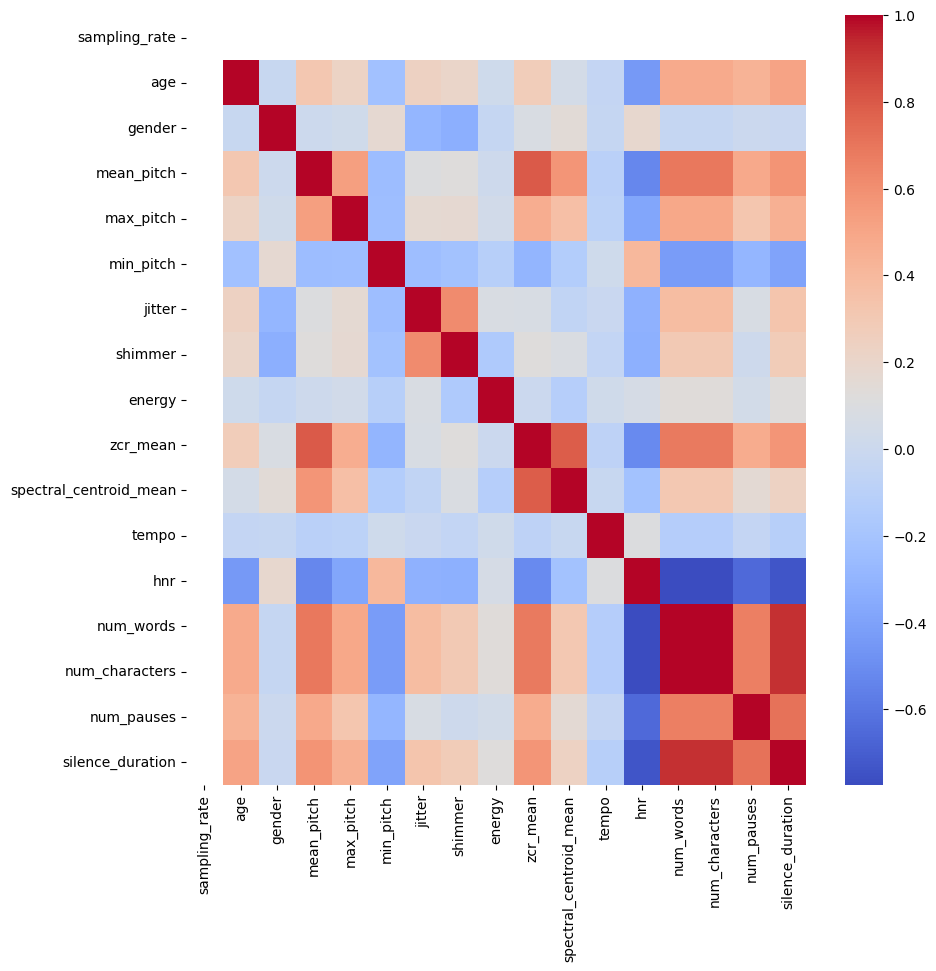

In [170]:
correlation_matrix(dev_df.drop(columns=["path", "ethnicity"]))

In [171]:
def plot_top_ethnicities(df, column='ethnicity', top_n=15):
    
    ethnicity_counts = df[column].value_counts().head(top_n)

    
    plt.figure(figsize=(10, 6))
    ethnicity_counts.sort_values().plot(kind='bar')
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Ethnicities')
    plt.title(f'Top {top_n} Most Frequent Ethnicities')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

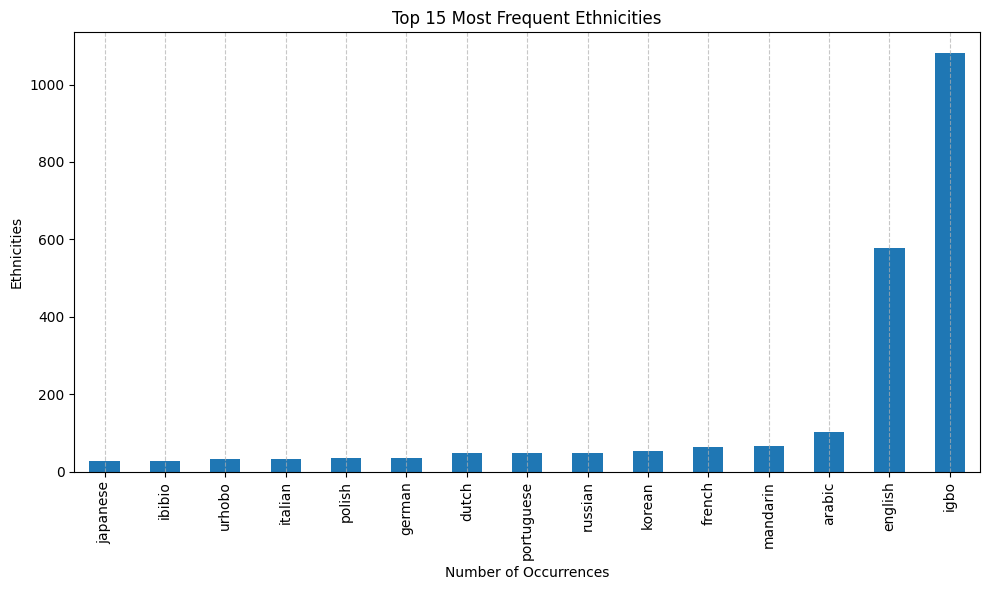

In [172]:
plot_top_ethnicities(dev_df)

In [173]:
top_ethnicity = dev_df["ethnicity"].value_counts().head(15).index
dev_df["ethnicity"] = dev_df["ethnicity"].apply(lambda x: x if x in top_ethnicity else "other")
eval_df["ethnicity"] = eval_df["ethnicity"].apply(lambda x: x if x in top_ethnicity else "other")

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(dev_df[["ethnicity"]])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [174]:
def encode(df, encoder):
    encoded_array = encoder.transform(df[["ethnicity"]])
    encoded_columns = encoder.get_feature_names_out(["ethnicity"])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)
    df = df.drop(columns=["ethnicity"]) 
    df = pd.concat([df, encoded_df], axis=1)
    return df

In [175]:
dev_df = encode(dev_df, encoder)
eval_df = encode(eval_df, encoder)

In [176]:
def plot_gender_histogram(data, gender_column):
    """
    Crea un istogramma per la distribuzione dei generi con tick personalizzati.
    
    :param data: Dataset (ad esempio un DataFrame)
    :param gender_column: Nome della colonna contenente i generi
    """
    gender_counts = data[gender_column].value_counts()
    
    labels_map = {0: 'Female', 1: 'Male'}
    custom_labels = [labels_map.get(label, label) for label in gender_counts.index]
    
    plt.figure(figsize=(8, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'], alpha=0.7, edgecolor='black')
    plt.title("Gender distribution", fontsize=14)
    plt.xlabel("Gender", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(ticks=gender_counts.index, labels=custom_labels, fontsize=11)
    plt.tight_layout()
    plt.show()


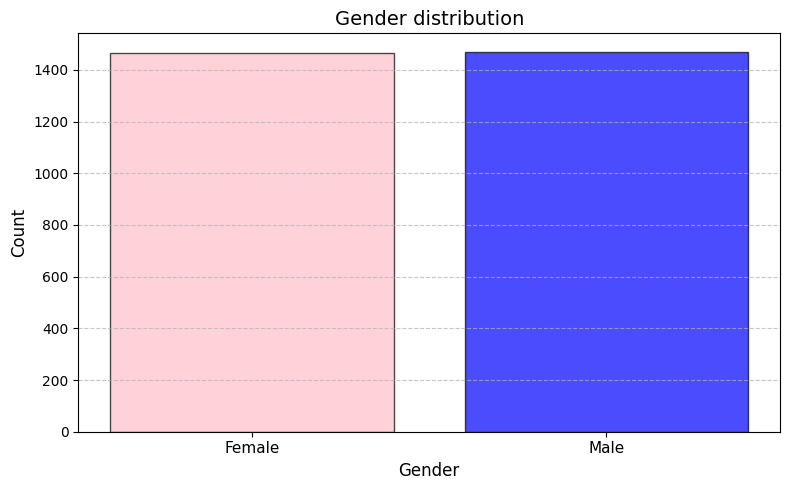

In [177]:
plot_gender_histogram(dev_df, "gender")

In [178]:
def split_df(df, col):
    X=df.drop(columns=[col], inplace=False)
    y= df[col]
    return X, y

In [179]:
X, y_train= split_df(dev_df, "age")

In [180]:
def extract_features(df, file_name):
    y, sr = librosa.load(file_name)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    
    avg=np.mean(log_spectrogram)
    std= np.std(log_spectrogram)
    
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=100)
    delta_mfcc_1 = librosa.feature.delta(mfcc, order=1)
    delta_mfcc_2 = librosa.feature.delta(mfcc, order=2)
    freqs = librosa.fft_frequencies(sr=sr)
    freq_skew = skew(freqs)
    freq_kurtosis = kurtosis(freqs)
    

    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_contrast_mean = np.mean(spectral_contrast)
    spectral_flatness_mean = np.mean(spectral_flatness)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    chroma_mean = np.mean(chroma)
    mfcc_mean = np.mean(mfcc)
    delta_mfcc_mean_1 = np.mean(delta_mfcc_1)
    delta_mfcc_mean_2 = np.mean(delta_mfcc_2)
    freq_mean= np.mean(freqs)
    freq_std= np.mean(freqs)

    spectral_bandwidth_std = np.std(spectral_bandwidth)
    spectral_contrast_std = np.std(spectral_contrast)
    spectral_flatness_std = np.std(spectral_flatness)
    spectral_rolloff_std = np.std(spectral_rolloff)
    chroma_std = np.std(chroma)
    mfcc_std = np.std(mfcc)
    delta_mfcc_std_1 = np.std(delta_mfcc_1)
    delta_mfcc_std_2 = np.std(delta_mfcc_2)
    
    
    
    return {
        "mean_spectrogram": avg,
        "std_spectrogram": std,
        "spectral_bandwidth_mean": spectral_bandwidth_mean,
        "spectral_bandwidth_std": spectral_bandwidth_std,
        "spectral_contrast_mean": spectral_contrast_mean,
        "spectral_contrast_std": spectral_contrast_std,
        "spectral_flatness_mean": spectral_flatness_mean,
        "spectral_flatness_std": spectral_flatness_std,
        "spectral_rolloff_mean": spectral_rolloff_mean,
        "spectral_rolloff_std": spectral_rolloff_std,
        "chroma_mean": chroma_mean,
        "chroma_std": chroma_std,
        "mfcc": mfcc,
        "mfcc_mean": mfcc_mean,
        "mfcc_std": mfcc_std,
        "delta_mfcc_mean_1": delta_mfcc_mean_1,
        "delta_mfcc_std_1": delta_mfcc_std_1,
        "delta_mfcc_mean_2": delta_mfcc_mean_2,
        "delta_mfcc_std_2": delta_mfcc_std_2,
        "freq_mean":freq_mean,
        "freq_std":freq_std,
        "skew": freq_skew,
        "kurtosis": freq_kurtosis
        
    }

In [181]:
def add_features(df, audio_folder):
    audio_df= pd.DataFrame(columns=[
       "mean_spectrogram",
        "std_spectrogram",
        "spectral_bandwidth_mean",
        "spectral_bandwidth_std",
        "spectral_contrast_mean",
        "spectral_contrast_std" ,
        "spectral_flatness_mean",
        "spectral_flatness_std", 
        "spectral_rolloff_mean" ,
        "spectral_rolloff_std",
        "chroma_mean",
        "chroma_std",
        "mfcc_mean",
        "mfcc_std",
        "delta_mfcc_mean_1",
        "delta_mfcc_std_1",
        "delta_mfcc_mean_2",
        "delta_mfcc_std_2",
        "freq_mean",
        "freq_std",
        "skew",
        "kurtosis"
        ])
    rows = []
    mfcc_means = []
    mfcc_stds = []

    df["path"]= pd.Series(["DSL_Winter_Project_2025/" + x for x in df["path"]])
    for file_name in tqdm(df["path"]):
        features = extract_features(df, file_name)
        mfcc_df = pd.DataFrame(features["mfcc"])
        features.pop("mfcc")
        mfcc_mean_df = np.mean(mfcc_df, axis=1)
        mfcc_std_df = np.std(mfcc_df, axis=1)
        rows.append(features)
        mfcc_means.append(mfcc_mean_df)
        mfcc_stds.append(mfcc_std_df)

    audio_df = pd.DataFrame(rows)
    mfcc_mean_df = pd.DataFrame(mfcc_means)
    mfcc_std_df = pd.DataFrame(mfcc_stds)
    
    total_df = pd.concat((df, audio_df),axis=1)
    total_mfcc_df = pd.concat((total_df, mfcc_mean_df),axis=1)
    
    total_df = pd.concat((total_mfcc_df, mfcc_std_df), axis=1)
    
    
    return total_df

In [182]:
X_train = add_features(X, "/DSL_Winter_Project_2025/audios_development")

100%|██████████| 2933/2933 [20:49<00:00,  2.35it/s]


In [183]:
X_train.to_csv("X_train_total.csv", index=False)

In [184]:
X_test = add_features(eval_df, "DSL_Winter_Project_2025/audios_evaluation")

100%|██████████| 691/691 [05:31<00:00,  2.09it/s]


In [185]:
X_test.to_csv("X_test_total.csv", index=False)

In [139]:
X_train.drop(columns=("path"), inplace=True)
X_test.drop(columns=("path"), inplace=True)

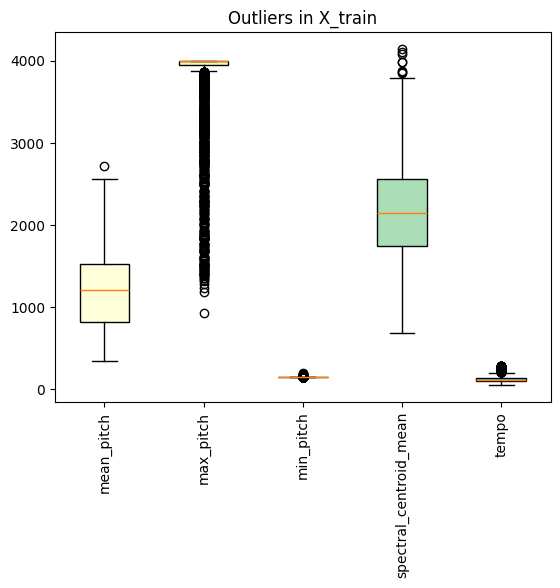

In [140]:
cmap = plt.get_cmap("YlGnBu")
colors = cmap(np.linspace(0.0, 0.4, 5))

plt.subplot()
box = plt.boxplot(X_train.loc[:, ["mean_pitch", "max_pitch", "min_pitch", "spectral_centroid_mean", "tempo"]], tick_labels=X_train.columns[[2,3,4,9,10]], patch_artist=True)
plt.xticks(rotation=90)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Outliers in X_train")
plt.show()

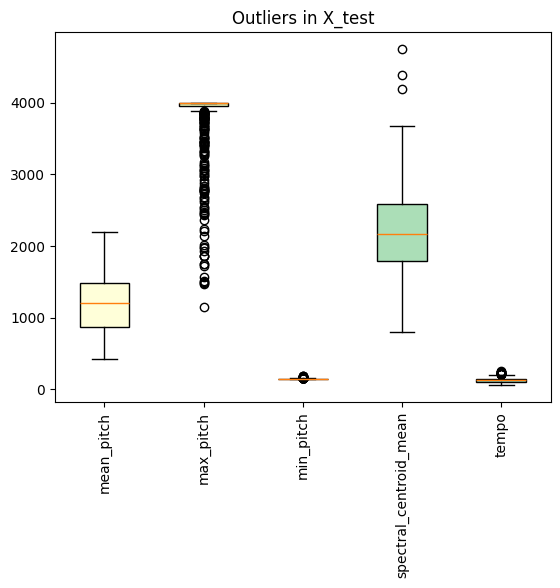

In [141]:
cmap = plt.get_cmap("YlGnBu")
colors = cmap(np.linspace(0.0, 0.4, 5))

plt.subplot()
box = plt.boxplot(X_test.loc[:, ["mean_pitch", "max_pitch", "min_pitch", "spectral_centroid_mean", "tempo"]], tick_labels=X_test.columns[[2,3,4,9,10]], patch_artist=True)
plt.xticks(rotation=90)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Outliers in X_test")
plt.show()

In [142]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [143]:
std=StandardScaler()
X_std=pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)

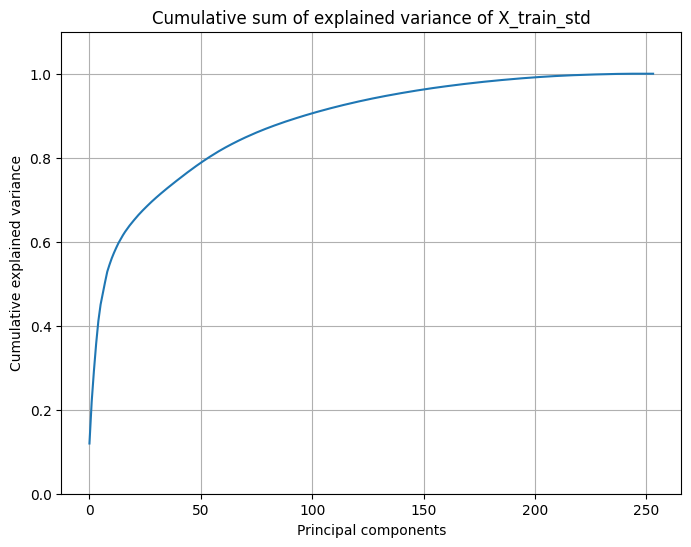

In [144]:
pca= PCA()
pca.fit(X_std.values)

round_expl_var_ratio = np.round(pca.explained_variance_ratio_.sum()*100,decimals=2)

plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance of X_train_std')
plt.ylim([0, 1.1])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.ylim()
plt.grid()
plt.show()

In [145]:
# models=[
#     LinearRegression(),
#     Ridge(),
#     Lasso(),
#     MLPRegressor(),
#     SVR(),
#     RandomForestRegressor(),
#     DecisionTreeRegressor(),
#     RANSACRegressor(),
#     HuberRegressor(),
#     GradientBoostingRegressor(),
#     HistGradientBoostingRegressor()
# ]


# names=[
#     'LinearRegression',
#     'Ridge',
#     "Lasso",
#     'MLPRegressor',
#     'SVR',
#     'RandomForestRegressor',
#     "DecisionTreeRegressor",
#     "RANSACRegressor",
#     "HuberRegressor",
#     "GradientBoostingRegressor",
#     "HistGradientBoostingRegressor"
# ]

# param_grid = {
#     "LinearRegression": {
#         "fit_intercept": [True, False]
#     },
#     "Ridge": {
#         "alpha": [0.01, 0.1, 1, 10],
#         "solver": ['auto', 'svd', 'cholesky', 'lsqr']
#     },
#     "Lasso": {
#         # "alpha": [0.01, 0.1, 1, 10]
#     },
#     "MLPRegressor": {
#         "hidden_layer_sizes": [(10, 10), (50, 50), (100,)],
#         "activation": ['tanh', 'relu', 'logistic'],
#         "alpha": [0.001, 0.01],
#         "learning_rate": ['constant', 'adaptive'],
#         "max_iter": [1000, 5000]
#     },
#     "SVR": {
#         "C": [0.1, 1, 10],
#         "epsilon": [0.01, 0.1, 0.5],
#         "kernel": ['linear', 'rbf', 'poly'],
#         "gamma": ['scale', 'auto']
#     },
#    "RandomForestRegressor": {
#         "n_estimators": [100, 200],
#         "max_depth": [None, 10, 20],
#         "min_samples_split": [2, 5],
#         "max_features": ['sqrt', 'log2', None]
#     },
#     "DecisionTreeRegressor": {
#         "max_depth": [None, 10, 20],
#         "min_samples_split": [2, 5, 10],
#         "min_samples_leaf": [1, 2, 5],
#         "max_features": ['sqrt', 'log2', None]
#     },
    
#     "RANSACRegressor": {
#     "estimator": [LinearRegression(), Ridge(), Lasso()],
#     "min_samples": [0.5, 0.7, 0.9],
#     "residual_threshold": [1.0, 5.0, 10.0],
#     "max_trials": [100, 500],
# },
#     "HuberRegressor": {
#     "epsilon": [1.0, 1.1, 1.35],
#     "alpha": [0.2, 0.3, 0.4],
#     "max_iter": [100, 500, 1000],
#     "tol": [1e-4, 1e-6],
#     "fit_intercept": [True, False]
# },
#     "GradientBoostingRegressor": {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'subsample': [0.8, 0.9, 1.0],
#     'loss': ['squared_error', 'absolute_error']
# }
# }

In [146]:
gbr = GradientBoostingRegressor()
hgbr = HistGradientBoostingRegressor()

In [147]:
X_train=X_train.drop(columns=['spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'chroma_mean', 'chroma_std', 'freq_mean', 'freq_std',
       'skew', 'kurtosis' ])
X_test=X_test.drop(columns=['spectral_contrast_mean',
       'spectral_contrast_std', 'spectral_flatness_mean',
       'spectral_flatness_std', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'chroma_mean', 'chroma_std', 'freq_mean', 'freq_std',
       'skew', 'kurtosis' ])

In [148]:
std=StandardScaler()
X_std=pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)

In [149]:

def KFold_grid(model, name):
    k_values = [3, 5, 8, 9, 10, 11, 12]
    best_rmse = float("inf")
    k_rmse_results = []

    for k in k_values:
        print(f"\nEvaluating models with KFold n_splits={k}...")
        kf = KFold(n_splits=k, shuffle=True, random_state=21)
        
        print(f"Optimizing {name}...")
        rmses = []

        for train_index, eval_index in kf.split(X_std):
            X_train_part, X_eval = X_std.loc[train_index], X_std.loc[eval_index]
            y_train_part, y_eval = y_train.loc[train_index], y_train.loc[eval_index]

            model.fit(X_train_part, y_train_part)

            y_pred_eval = model.predict(X_eval)

            rmse = root_mean_squared_error(y_eval, y_pred_eval)
            rmses.append(rmse)

        mean_rmse = np.mean(rmses)
        print(f"Average RMSE for {name} with K={k}: {mean_rmse:.4f}")
        
        k_rmse_results.append((k, mean_rmse))
        
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_k = k
            
    print(f"\nFinal best model across all K: {name} with k={best_k}, RMSE: {best_rmse:.4f}")
    return k_values, k_rmse_results, best_k

In [150]:
k_values_hist, k_rmse_results_hist, best_k_hist = KFold_grid(hgbr, "HistGradientBoostingRegressor")


Evaluating models with KFold n_splits=3...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=3: 9.7501

Evaluating models with KFold n_splits=5...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=5: 9.6363

Evaluating models with KFold n_splits=8...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=8: 9.6904

Evaluating models with KFold n_splits=9...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=9: 9.6610

Evaluating models with KFold n_splits=10...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=10: 9.6452

Evaluating models with KFold n_splits=11...
Optimizing HistGradientBoostingRegressor...
Average RMSE for HistGradientBoostingRegressor with K=11: 9.7594

Evaluating models with KFold n_splits=12...
Optimizing HistGradientBoostingRegresso

In [151]:
k_values_gbr, k_rmse_results_gbr, best_k_gbr = KFold_grid(gbr, "GradientBoostingRegressor")


Evaluating models with KFold n_splits=3...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=3: 10.0363

Evaluating models with KFold n_splits=5...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=5: 9.9376

Evaluating models with KFold n_splits=8...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=8: 9.9080

Evaluating models with KFold n_splits=9...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=9: 9.8993

Evaluating models with KFold n_splits=10...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=10: 9.9393

Evaluating models with KFold n_splits=11...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor with K=11: 9.8952

Evaluating models with KFold n_splits=12...
Optimizing GradientBoostingRegressor...
Average RMSE for GradientBoostingRegressor wit

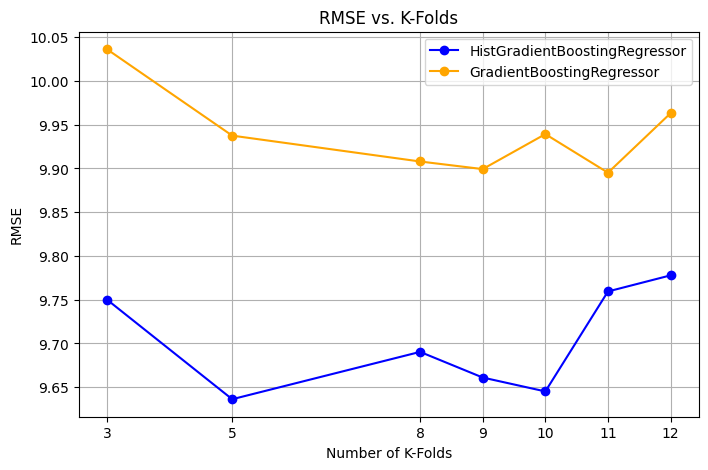

In [152]:
k_values_plot_hist, rmse_values_plot_hist = zip(*k_rmse_results_hist)
k_values_plot_gbr, rmse_values_plot_gbr = zip(*k_rmse_results_gbr)

plt.figure(figsize=(8, 5))
plt.plot(k_values_plot_hist, rmse_values_plot_hist, marker='o', linestyle='-', color='b', label="HistGradientBoostingRegressor")
plt.plot(k_values_plot_gbr, rmse_values_plot_gbr, marker='o', linestyle='-', color='orange', label="GradientBoostingRegressor")

plt.xlabel("Number of K-Folds")
plt.ylabel("RMSE")
plt.title("RMSE vs. K-Folds")
plt.xticks(k_values_hist)
plt.grid()
plt.legend()
plt.show()

In [153]:
kf = KFold(n_splits=best_k_hist, shuffle=True, random_state=21) 

best_rmse = float("inf")

print(f"Optimizing HistGradientBoostingRegressor...")
rmses = [] 

for train_index, eval_index in kf.split(X_std):
    X_std_part, X_eval = X_std.loc[train_index], X_std.loc[eval_index]
    y_train_part, y_eval = y_train.loc[train_index], y_train.loc[eval_index]
    
    hgbr.fit(X_std_part, y_train_part)

    y_predeval = hgbr.predict(X_eval)

    rmse = root_mean_squared_error(y_eval, y_predeval)
    rmses.append(rmse)

mean_rmse = np.mean(rmses)

if mean_rmse < best_rmse:
    best_rmse = mean_rmse
    X_test_std = std.transform(X_test)
    y_pred = hgbr.predict(X_test_std)

print(f"Best model: HistGradientBoostingRegressor, RMSE: {best_rmse:.4f}")

Optimizing HistGradientBoostingRegressor...
Best model: HistGradientBoostingRegressor, RMSE: 9.6363


In [154]:
submission = pd.DataFrame(columns=["Id","Predicted"])
submission["Id"] = complete_eval_df["Id"]
submission["Predicted"] = y_pred
submission.to_csv("final_submission_kfold.csv", index=False)

In [155]:
X_train=pd.read_csv("X_train_total.csv")
X_test=pd.read_csv("X_test_total.csv")
X_train=X_train.drop(columns=["path"])
X_test=X_test.drop(columns=["path"])

In [156]:
std=StandardScaler()
X_std=pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)

In [157]:
hgbr.fit(X_std, y_train)
X_test_std = std.transform(X_test)
y_pred= hgbr.predict(X_test_std)

In [158]:
submission = pd.DataFrame(columns=["Id","Predicted"])
submission["Id"] = complete_eval_df["Id"]
submission["Predicted"] = y_pred
submission.to_csv("final_submission_all.csv", index=False)

In [159]:
X_train=X_train.drop(columns=['spectral_contrast_mean',
    'spectral_contrast_std', 'spectral_flatness_mean',
    'spectral_flatness_std', 'spectral_rolloff_mean',
    'spectral_rolloff_std', 'chroma_mean', 'chroma_std', 'freq_mean', 'freq_std',
    'skew', 'kurtosis' ])
X_test=X_test.drop(columns=['spectral_contrast_mean',
    'spectral_contrast_std', 'spectral_flatness_mean',
    'spectral_flatness_std', 'spectral_rolloff_mean',
    'spectral_rolloff_std', 'chroma_mean', 'chroma_std', 'freq_mean', 'freq_std',
    'skew', 'kurtosis' ])

In [160]:
std=StandardScaler()
X_std=pd.DataFrame(std.fit_transform(X_train), columns=X_train.columns)

In [161]:
hgbr.fit(X_std, y_train)
X_test_std = std.transform(X_test)
y_pred= hgbr.predict(X_test_std)

In [162]:
submission = pd.DataFrame(columns=["Id","Predicted"])
submission["Id"] = complete_eval_df["Id"]
submission["Predicted"] = y_pred
submission.to_csv("final_submission_best.csv", index=False)